# Random Forest with PCA dimension reduction and Gridsearch

In [1]:
import numpy as np # numbers and algebra in python
import pandas as pd # tables and processing tabular data


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dirPath = './archive/CMaps/'

train = pd.read_csv(dirPath + 'train_FD001.txt',sep='\s+',names=col_names)
test = pd.read_csv(dirPath + 'test_FD001.txt',sep='\s+',names=col_names)
y_test = pd.read_csv(dirPath + 'RUL_FD001.txt',sep='\s+',header=None)

In [5]:
train[index_names].groupby('unit_number').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [6]:
def gate_the_RUL(train,cap=150):
    # Rectifier
    train['RUL'] = np.minimum(train['RUL'],cap)
    return train

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

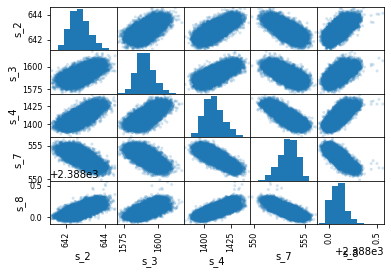

In [7]:
# Here are a small selection of useful looking signals, along with our taregt (RUL)
good_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8']
pd.plotting.scatter_matrix(train.loc[:,good_sensors], alpha=0.2)
plt.show()

As we discussed last week, we can gate the RUL during training if we "don't care about it above a threshold".
Consider histograms later in this script to understand why

In [8]:
train = add_remaining_useful_life(train)
train = gate_the_RUL(train,cap=150)

train[index_names+['RUL']] # last thing in cell prints out

,unit_number,time_cycles,RUL
0,1,1,150
1,1,2,150
2,1,3,150
3,1,4,150
4,1,5,150
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


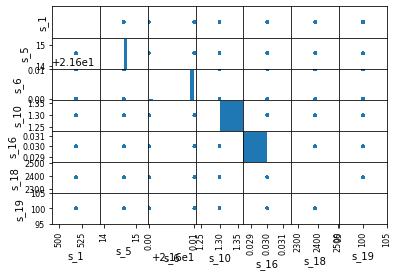

In [9]:
# these seem not worth keeping
import warnings
warnings.filterwarnings("ignore")
# drop_sensors = ['s_1','s_5','s_16','s_18','s_19'] # as per last week..
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19'] # new bad signals noted. 

pd.plotting.scatter_matrix(train.loc[:,drop_sensors])
plt.show()

In [10]:
# this time let's keep the cycles (normalised) showing current engine life
drop_labels = setting_names+drop_sensors # ['unit_number'] was index_names
 # last time we dropped ['unit_number'] here

In [11]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [13]:
X_test

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,97,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,98,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,99,97,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


If we wished to investigate whether moving averages would help on the training data, remove """ in the cell below.

We could apply to test data, but this might be seen as cheating!
the question is.. does 'smoothing' inputs, assist with unaltered test data?

In [14]:
"""
X_train = X_train.groupby('unit_number').rolling(5,min_periods=1).sum()
# X_test = X_test.groupby('unit_number').rolling(5,min_periods=1).sum() # should apply train only.
drop_labels = ['unit_number']
X_train = X_train.drop(drop_labels, axis=1)
X_test = X_test.drop(drop_labels, axis=1)
"""

"\nX_train = X_train.groupby('unit_number').rolling(2,min_periods=1).sum()\n# X_test = X_test.groupby('unit_number').rolling(2,min_periods=1).sum() # should apply train only.\ndrop_labels = ['unit_number']\nX_train = X_train.drop(drop_labels, axis=1)\nX_test = X_test.drop(drop_labels, axis=1)\n"

In [15]:
# zero-centered normalise (standardise or zscore)

X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [16]:
from sklearn.decomposition import PCA
reduce_dim = 8

pca = PCA(n_components=reduce_dim)
pca.fit(X_train)

print(pca.explained_variance_ratio_)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

feature_names = ['pca_{}'.format(i+1) for i in range(0,reduce_dim)]
feature_names

[0.59276809 0.13579847 0.06275434 0.02735979 0.02573127 0.02301262
 0.02159708 0.01912975]


['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']

In [17]:
img_rows, img_cols = 1, reduce_dim
input_shape = (img_rows, img_cols, 1)

In [18]:
X_train.shape

(20631, 8)

In [19]:
regr = RandomForestRegressor(max_depth=5, random_state=123)
regr.fit(X_train, y_train) # prior learning

RandomForestRegressor(max_depth=5, random_state=123)

In [20]:
model_pred = regr.predict(X_test) # inferencing

In the next section we define a custom metric, we manually split and shuffle data

In [21]:
from sklearn.metrics import r2_score

In [22]:
r2_score(y_test,model_pred)

0.6296264537712191

In [23]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  25.290053729216872


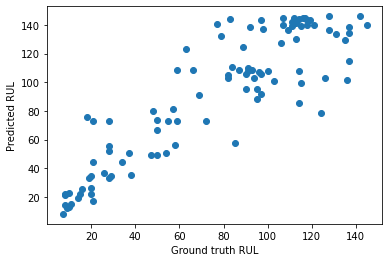

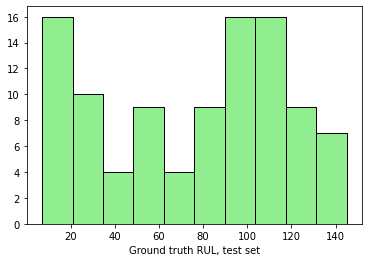

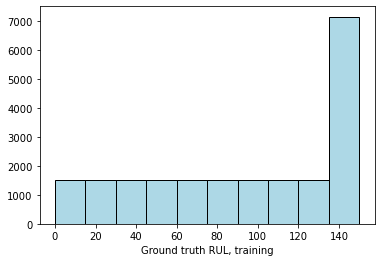

In [24]:
plt.scatter(y_test,model_pred)
plt.xlabel("Ground truth RUL")
plt.ylabel("Predicted RUL")
plt.show()

plt.hist(y_test, color = "lightgreen", ec="black")
plt.xlabel("Ground truth RUL, test set")
plt.show()

plt.hist(y_train, color = "lightblue", ec="black")
plt.xlabel("Ground truth RUL, training")
plt.show()

In [25]:
# outer loop auto-ML
# set random state for repeatability
from sklearn.model_selection import GridSearchCV
## Define Grid 
grid = { 
    'n_estimators': [25,50,100],
    'max_depth' : [3,4,5],
    'random_state' : [18]
}

## Grid Search function
CV_rforest = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rforest.fit(X_train, y_train)
## show end time


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5], 'n_estimators': [25, 50, 100],
                         'random_state': [18]})

In [26]:
model_gs = CV_rforest.best_estimator_
model_pred = model_gs.predict(X_test)

In [27]:
r2_score(y_test,model_pred)

0.6293946357078233

In [28]:
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  25.297967056526208


Let's now plot the first tree in our ensemble. Remember there are many weak learners (trees) within the RandomForest model. We can access them by index 0,1,2..
Here, I've commented the long printout, leaving just an image of the start of it.

In [29]:
from sklearn import tree
# print(tree.export_text(model_gs.estimators_[0]))

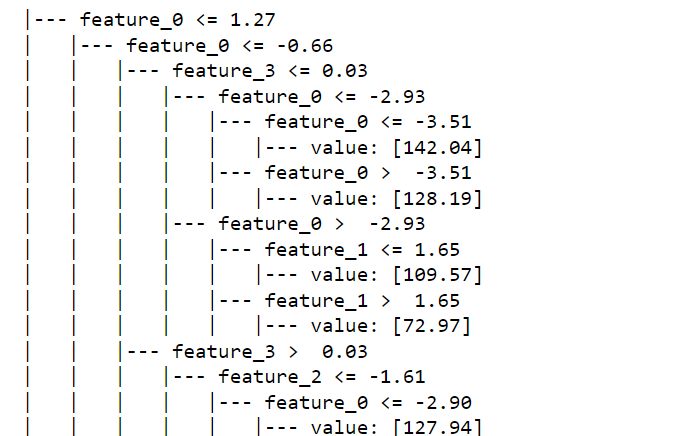

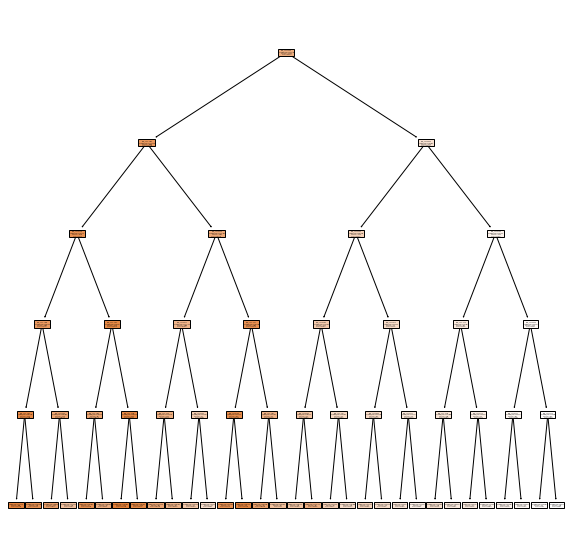

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(model_gs.estimators_[0], feature_names = feature_names, class_names = y_train, filled=True)
plt.show()

How many trees are in our total ensemble?
What are the model's (estimator's) parameters, that we could vary/tune?

In [31]:
len(model_gs.estimators_)

50

In [32]:
print(model_gs.estimator_params)

('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha')
